This notebook demonstrates two distinct Python applications:
1.  **Natural Language Processing (NLP) for Relation Extraction:** Using `spaCy`, this section processes sample sentences to identify named entities (PERSON, ORG) and extract "works for" relationships. These relationships are then visualized as a knowledge graph using `NetworkX` and `Matplotlib`.
2.  **Conceptual Cognitive Map Visualization:** Using `NetworkX`, this section constructs and visualizes a simple cognitive map, demonstrating how to represent causal or influential relationships, including conjunctive logic (AND-nodes).

The primary purpose of this notebook is to showcase proficiency in:
*   Python programming.
*   Utilizing NLP libraries like `spaCy` for text processing.
*   Graph data structures and visualization with `NetworkX`.
*   Data visualization with `Matplotlib`.
*   Structuring and presenting data-driven insights.

## Part 1: NLP for "Works For" Relation Extraction
This section focuses on extracting structured information (who works for which organization) from unstructured text.

In [1]:
# Import necessary libraries
import spacy
import networkx as nx
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the spaCy language model
def load_spacy_model(model_name="en_core_web_sm"):
    """Loads the spaCy language model with error handling."""
    try:
        nlp_model = spacy.load(model_name)
        print(f"Spacy model '{model_name}' loaded successfully.")
        return nlp_model
    except OSError:
        print(f"Spacy model '{model_name}' not found. Please download it by running:\n"
              f"python -m spacy download {model_name}")
        return None

nlp = load_spacy_model()

Spacy model 'en_core_web_sm' loaded successfully.


### 1.1 Sample Sentences and Basic NLP Processing
We'll start with a few sample sentences. For each sentence, we'll perform tokenization, Part-of-Speech (POS) tagging, and Named Entity Recognition (NER).

In [12]:
# Define sample sentences
sample_sentences = [
    "Alice works for Acme Corp.",
    "Bob works for Acme Corp.",
    "Charlie works for Globex Inc.",
    "Diana works for Globex Inc.",
]

print("Sample sentences:")
for s in sample_sentences:
    print("-", s)

print("\n--- Basic NLP Processing ---")
if nlp:
    for sentence_text in sample_sentences:
        doc = nlp(sentence_text)
        tokens_pos = [(token.text, token.pos_) for token in doc]
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        print(f"\nSentence: {sentence_text}")
        print("Tokens and POS:", tokens_pos)
        print("Named Entities:", entities)
else:
    print("SpaCy model not loaded. Cannot perform NLP processing.")

Sample sentences:
- Alice works for Acme Corp.
- Bob works for Acme Corp.
- Charlie works for Globex Inc.
- Diana works for Globex Inc.

--- Basic NLP Processing ---

Sentence: Alice works for Acme Corp.
Tokens and POS: [('Alice', 'PROPN'), ('works', 'VERB'), ('for', 'ADP'), ('Acme', 'PROPN'), ('Corp.', 'PROPN')]
Named Entities: [('Alice', 'PERSON'), ('Acme Corp.', 'ORG')]

Sentence: Bob works for Acme Corp.
Tokens and POS: [('Bob', 'PROPN'), ('works', 'VERB'), ('for', 'ADP'), ('Acme', 'PROPN'), ('Corp.', 'PROPN')]
Named Entities: [('Bob', 'PERSON'), ('Acme Corp.', 'ORG')]

Sentence: Charlie works for Globex Inc.
Tokens and POS: [('Charlie', 'PROPN'), ('works', 'VERB'), ('for', 'ADP'), ('Globex', 'PROPN'), ('Inc.', 'PROPN')]
Named Entities: [('Charlie', 'PERSON'), ('Globex Inc.', 'ORG')]

Sentence: Diana works for Globex Inc.
Tokens and POS: [('Diana', 'PROPN'), ('works', 'VERB'), ('for', 'ADP'), ('Globex', 'PROPN'), ('Inc.', 'PROPN')]
Named Entities: [('Diana', 'PERSON'), ('Globex Inc

### 1.2 Extracting "Works For" Relations
Now, we define a function to extract "works for" (or similar) relations. The logic looks for a VERB (like "work", "employed") and identifies a PERSON as its subject and an ORGANIZATION as the object of a preposition like "for" or "by".

In [13]:
def extract_work_relations(doc):
    """
    Extracts 'works for' or 'employed by' relations (Person, relation_verb, Organization)
    from a spaCy Doc.
    """
    relations = []
    # Define relevant verbs and prepositions
    WORK_VERBS = {"work", "employ"} # Lemmas
    ORG_PREPS = {"for", "by"} # Prepositions linking to organization

    for token in doc:
        # Look for verbs indicating employment
        if token.lemma_ in WORK_VERBS and token.pos_ == "VERB":
            person = None
            organization = None
            relation_verb = token.lemma_

            # Find the nominal subject (PERSON)
            for child in token.children:
                if child.dep_ == "nsubj" and child.ent_type_ == "PERSON":
                    person = child.text
                    break # Found person

            if not person and token.head.dep_ == "ROOT" and token.head.ent_type_ == "PERSON":
                for ancestor_child in token.head.children:
                    if ancestor_child.dep_ == "nsubjpass" and ancestor_child.ent_type_ == "PERSON":
                        person = ancestor_child.text
                        break
            if not person:
                 for possible_subject in token.children:
                    if possible_subject.dep_ == "nsubj":
                        for sub_token in possible_subject.conjuncts:
                            if sub_token.ent_type_ == "PERSON":
                                person = sub_token.text
                                break
                        if person: break
                        if possible_subject.ent_type_ == "PERSON":
                            person = possible_subject.text
                            break


            # Find the prepositional object (ORGANIZATION) linked by "for" or "by"
            for child in token.children:
                if child.dep_ == "prep" and child.text.lower() in ORG_PREPS:
                    for grandchild in child.children:
                        if grandchild.dep_ == "pobj" and grandchild.ent_type_ == "ORG":
                            organization = grandchild.text
                            break
                    if organization:
                        break

            # For passive voice like "Eve is employed by Stark Industries"
            if not organization and token.dep_ == "acl":
                 if token.head.ent_type_ == "PERSON":
                    person = token.head.text
                    for child in token.children:
                        if child.dep_ == "agent" and child.text.lower() == "by":
                            for grandchild in child.children:
                                if grandchild.dep_ == "pobj" and grandchild.ent_type_ == "ORG":
                                    organization = grandchild.text
                                    break
                            if organization: break


            if person and organization:
                relations.append((person, f"{relation_verb} {child.text.lower() if child else ''}".strip(), organization))
                # Also check for conjunctions of organizations
                for conj_org in grandchild.conjuncts if 'grandchild' in locals() and grandchild else []:
                    if conj_org.ent_type_ == "ORG":
                        relations.append((person, f"{relation_verb} {child.text.lower() if child else ''}".strip(), conj_org.text))


    return relations

print("--- Extracting Relations ---")
all_relations = []
if nlp:
    for sentence_text in sample_sentences:
        doc = nlp(sentence_text)
        extracted = extract_work_relations(doc)
        if extracted:
            for rel in extracted:
                print(f"Extracted relation: {rel[0]} -> {rel[1]} -> {rel[2]}")
            all_relations.extend(extracted)
else:
    print("SpaCy model not loaded. Cannot extract relations.")

if not all_relations and nlp:
    print("No 'works for' relations found in the sample sentences with the current rules.")

--- Extracting Relations ---
Extracted relation: Alice -> work for -> Corp.
Extracted relation: Bob -> work for -> Corp.
Extracted relation: Charlie -> work for -> Inc.
Extracted relation: Diana -> work for -> Inc.


### 1.3 Creating and Visualizing the Knowledge Graph
The extracted relations are used to build a directed graph where nodes are people or organizations, and edges represent the "works for" relationship.


--- Knowledge Graph Summary ---
Entities in graph: [('Alice', {'label': 'PERSON'}), ('Corp.', {'label': 'ORG'}), ('Bob', {'label': 'PERSON'}), ('Charlie', {'label': 'PERSON'}), ('Inc.', {'label': 'ORG'}), ('Diana', {'label': 'PERSON'})]
Relations in graph: [('Alice', 'Corp.', {'label': 'work for'}), ('Bob', 'Corp.', {'label': 'work for'}), ('Charlie', 'Inc.', {'label': 'work for'}), ('Diana', 'Inc.', {'label': 'work for'})]


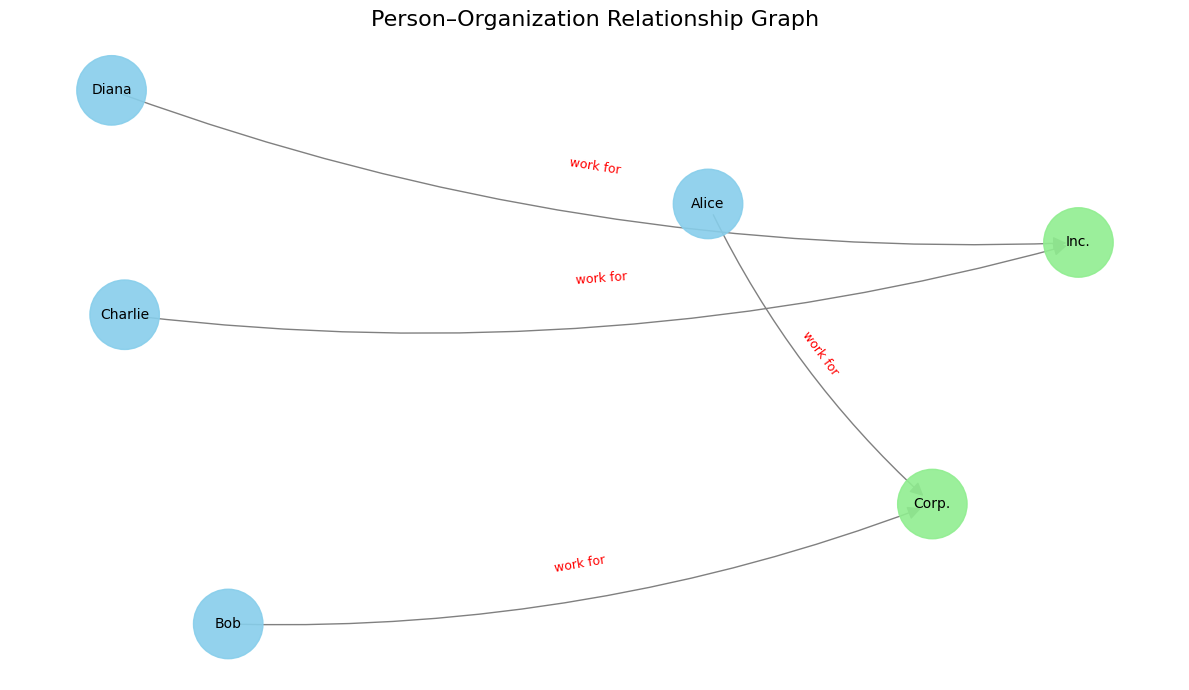

In [14]:
def create_relation_graph(relations_list):
    """Creates a NetworkX DiGraph from a list of (subject, relation_type, object) tuples."""
    G = nx.DiGraph()
    for subj, rel_type, obj in relations_list:
        G.add_node(subj, label="PERSON")
        G.add_node(obj, label="ORG")
        G.add_edge(subj, obj, label=rel_type)
    return G

def plot_knowledge_graph(G, title="Knowledge Graph", layout_k=1.5, seed=42):
    """Plots a NetworkX graph with specific styling for knowledge graphs."""
    if not G.nodes:
        print("Graph is empty, nothing to plot.")
        return

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, k=layout_k, seed=seed, iterations=50)

    node_colors = ['skyblue' if G.nodes[node]['label'] == 'PERSON' else 'lightgreen' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2500, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='-|>', arrowsize=20, connectionstyle='arc3,rad=0.1')

    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=9)

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

if all_relations:
    relation_graph = create_relation_graph(all_relations)
    print("\n--- Knowledge Graph Summary ---")
    print("Entities in graph:", relation_graph.nodes(data=True))
    print("Relations in graph:", relation_graph.edges(data=True))
    plot_knowledge_graph(relation_graph, title="Person–Organization Relationship Graph")
else:
    print("\nNo relations extracted to build a graph.")

## Part 2: Creating a Conceptual Cognitive Map

This section demonstrates how to use `NetworkX` to build and visualize a simple conceptual cognitive map. Cognitive maps represent beliefs, motivations, and their perceived causal relationships. This example includes "AND" nodes to model conjunctive influences.

In [15]:
def create_cognitive_map_graph():
    """Creates a NetworkX DiGraph representing the cognitive map."""
    G_cog = nx.DiGraph()

    # Define concept nodes
    concept_nodes = [
        "Strained living conditions", "Negative experience with state",
        "Duty for action", "Obedience to God", "Nonviolent dissent"
    ]
    G_cog.add_nodes_from(concept_nodes)

    # Define AND-nodes
    G_cog.add_node("AND1", conjunction=True, label_text="AND")
    G_cog.add_node("AND2", conjunction=True, label_text="AND")


    G_cog.add_edge("Strained living conditions", "AND1", weight=0.7)
    G_cog.add_edge("Negative experience with state", "AND1", weight=0.8)
    #
    G_cog.add_edge("AND1", "Duty for action", weight=0.9)

    G_cog.add_edge("Duty for action", "AND2", weight=0.6)
    G_cog.add_edge("Obedience to God", "AND2", weight=0.9)
    G_cog.add_edge("AND2", "Nonviolent dissent", weight=1.0)

    return G_cog

cognitive_map_graph = create_cognitive_map_graph()
print("\n--- Cognitive Map Graph Summary ---")
print("Nodes:", cognitive_map_graph.nodes(data=True))
print("Edges:", cognitive_map_graph.edges(data=True))


--- Cognitive Map Graph Summary ---
Nodes: [('Strained living conditions', {}), ('Negative experience with state', {}), ('Duty for action', {}), ('Obedience to God', {}), ('Nonviolent dissent', {}), ('AND1', {'conjunction': True, 'label_text': 'AND'}), ('AND2', {'conjunction': True, 'label_text': 'AND'})]
Edges: [('Strained living conditions', 'AND1', {'weight': 0.7}), ('Negative experience with state', 'AND1', {'weight': 0.8}), ('Duty for action', 'AND2', {'weight': 0.6}), ('Obedience to God', 'AND2', {'weight': 0.9}), ('AND1', 'Duty for action', {'weight': 0.9}), ('AND2', 'Nonviolent dissent', {'weight': 1.0})]


Using Graphviz 'dot' layout for hierarchical structure.


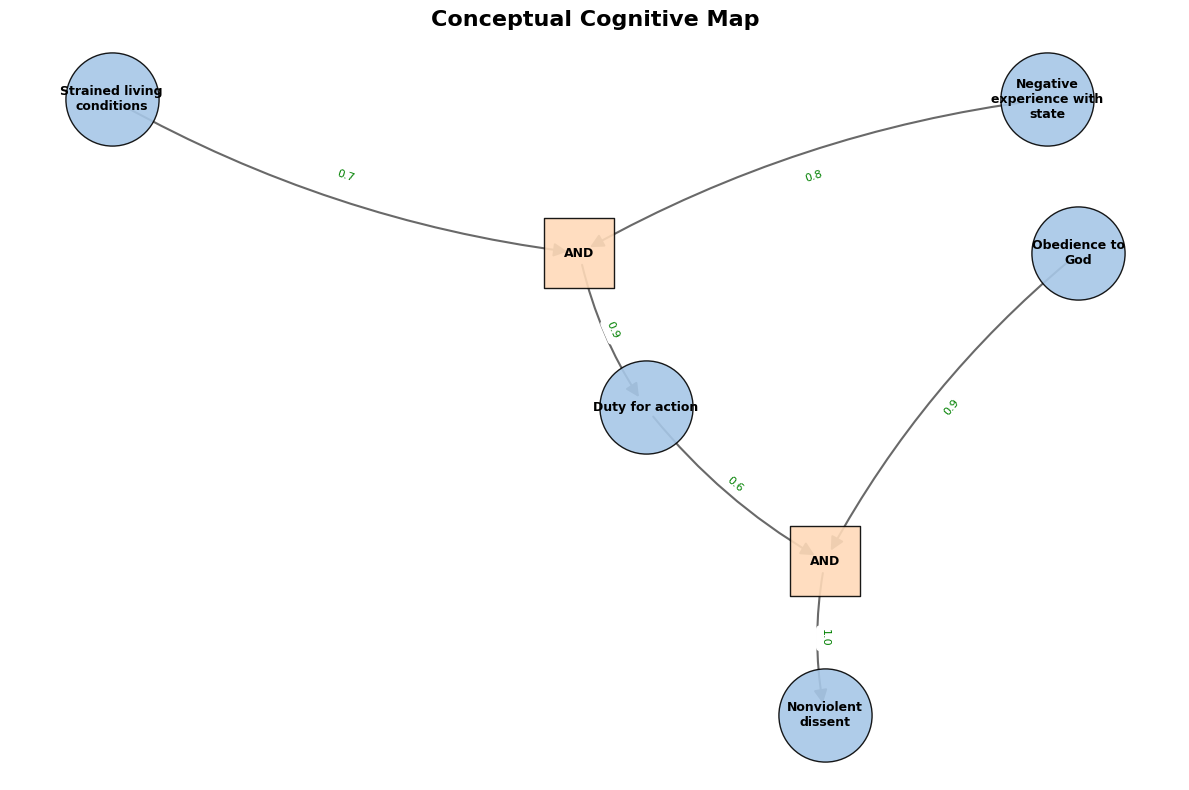

In [11]:
# --- Code Cell ---
def plot_cognitive_map(G, title="Conceptual Cognitive Map"):
    """Plots a cognitive map with distinct node styles for concepts and AND-nodes."""
    if not G.nodes:
        print("Cognitive map graph is empty, nothing to plot.")
        return

    plt.figure(figsize=(12, 8)) # Adjusted size for better readability

    # Attempt hierarchical layout, fallback to spring layout
    try:
        pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
        print("Using Graphviz 'dot' layout for hierarchical structure.")
    except Exception as e:
        print(f"Graphviz layout failed ({e}), using spring_layout as fallback.")
        pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42)

    # Separate nodes by type for different styling
    normal_nodes = [n for n, attrs in G.nodes(data=True) if not attrs.get("conjunction")]
    and_nodes    = [n for n, attrs in G.nodes(data=True) if attrs.get("conjunction")]

    # Draw concept nodes (circles)
    nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_color="#a7c7e7", node_shape="o",
                           node_size=4500, alpha=0.9, linewidths=1.0, edgecolors='black')
    # Draw AND-nodes (squares)
    nx.draw_networkx_nodes(G, pos, nodelist=and_nodes, node_color="#ffdAB9", node_shape="s",
                           node_size=2500, alpha=0.9, linewidths=1.0, edgecolors='black')

    # Prepare labels (wrapping long text, using "AND" for conjunction nodes)
    labels = {}
    for node, attrs in G.nodes(data=True):
        if attrs.get("conjunction"):
            labels[node] = attrs.get("label_text", "AND") # Use custom label_text or default to "AND"
        else:
            # Simple text wrapping for long labels
            words = node.split()
            max_len = 15 # Max characters per line
            current_line = ""
            formatted_label = ""
            for word in words:
                if len(current_line + " " + word) > max_len and current_line:
                    formatted_label += current_line + "\n"
                    current_line = word
                else:
                    current_line = (current_line + " " + word) if current_line else word
            formatted_label += current_line
            labels[node] = formatted_label.strip()

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold', font_color="black")

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=20,
                           width=1.5, edge_color="dimgray", connectionstyle='arc3,rad=0.1')

    # Optional: Draw edge weights if they exist
    edge_weights = nx.get_edge_attributes(G, 'weight')
    if edge_weights:
         nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=8, font_color='green')


    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
    plt.show()

plot_cognitive_map(cognitive_map_graph)